In [1]:
!pip install praw --quiet
import praw
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')

client_id = 'dTJ9j2l4eoJlFNShRL7tKQ'
client_secret = '_gVfSGggexB4rtfL5tazEKtmBAbwJg'
user_agent = 'DM_PROJECT1'
reddit = praw.Reddit(client_id=client_id, client_secret=client_secret, user_agent=user_agent, check_for_async=False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 2.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [16]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

# Function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Clean text
def clean_text(text):
    text = remove_stopwords(text)
    text = [word for word in word_tokenize(text)]  # split string into words
    text = [word for word in text if not re.match(r'[^\w\s]', word)]  # Remove punctuation
    return ' '.join(text)

# Sentiment analysis functions
def get_sentiment_score(text):
    words = text.split()
    sentiment_score = 0
    count = 0
    for word in words:
        if word.lower() in word_scores:
            sentiment_score += word_scores[word.lower()]
            count += 1
    if count == 0:
        return 0
    average_score = sentiment_score / count
    return average_score

def analyze_sentiment_nltk_vader(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

with open("AFINN-en-165.txt", "r") as afinn_file:
    afinn_data = afinn_file.readlines()

word_scores = {}
for line in afinn_data:
    word, score = line.strip().split('\t')
    word_scores[word] = int(score)

# get Reddit posts
hot_posts = reddit.subreddit('brexit').top(time_filter='all', limit=20)
all_comments_close_to_brexit = ""
all_positive_comments_close_to_brexit = ""
all_negative_comments_close_to_brexit = ""

data = []
for submission in hot_posts:
    mean_AFFINN_SCORE = 0
    mean_NLTK_SCORE = 0
    count = 0

    submission.comments.replace_more(limit=0)
    comments_list = submission.comments.list()[:20]

    for top_level_comment in comments_list:
        try:
            text = top_level_comment.body
            if text.strip():
                print("BEFORE CLEANING: " + text)
                cleaned_text = clean_text(text)
                print("AFTER CLEANING: " + cleaned_text)

                affin_score = get_sentiment_score(cleaned_text)
                nltk_score = analyze_sentiment_nltk_vader(cleaned_text)

                mean_AFFINN_SCORE += affin_score
                mean_NLTK_SCORE += nltk_score
                count += 1

                all_comments_close_to_brexit += cleaned_text

                if affin_score > 0:
                    all_positive_comments_close_to_brexit += cleaned_text
                elif affin_score < 0:
                    all_negative_comments_close_to_brexit += cleaned_text

        except AttributeError:

            continue

    if count > 0:
        comment_AFFIN_MEAN = mean_AFFINN_SCORE / count
        comment_NLTK_MEAN = mean_NLTK_SCORE / count
        data.append({
            'Post Name': submission.title,
            'AFFIN Score': comment_AFFIN_MEAN,
            'NLTK Score': comment_NLTK_MEAN
        })

df = pd.DataFrame(data, columns=['Post Name', 'AFFIN Score', 'NLTK Score'])
print(df)

close_to_brexit_afin_score = df["AFFIN Score"].mean()
close_to_brexit_nltk_score = df["NLTK Score"].mean()
print(f"Mean AFFIN Score: {close_to_brexit_afin_score}")
print(f"Mean NLTK Score: {close_to_brexit_nltk_score}")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


BEFORE CLEANING: Please note that this sub is for civil discussion. You are requested to familiarise yourself with the [subs rules](https://www.reddit.com/r/brexit/wiki/index) before participation.

*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/brexit) if you have any questions or concerns.*
AFTER CLEANING: please note sub civil discussion requested familiarise subs rules https participation i bot action performed automatically please contact moderators subreddit to=/r/brexit questions concerns
BEFORE CLEANING: You islandpeople really have.. ”interesting” newspapers.
AFTER CLEANING: islandpeople really have interesting newspapers
BEFORE CLEANING: There's a Dutch joke:a guy has died and gets tour of heaven from Peter. After a while they get to an enormous rack of church bells. The guy asks Peter:"so what this thing for". Peter answers:"for every lie that is told on earth, a bell rings. The bigger the l

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

all_text_data = all_comments_close_to_brexit

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit the vectorizer and transform the corpus
tfidf_matrix = vectorizer.fit_transform([all_text_data])

feature_names = vectorizer.get_feature_names_out()

# Calculate TF-IDF scores
tfidf_scores = tfidf_matrix.toarray()[0]

# Create DataFrame to hold words and their TF-IDF scores
data_term_frequency = pd.DataFrame({
    'word': feature_names,
    'tf_idf': tfidf_scores
})

# Sort by TF-IDF score
data_term_frequency_sorted = data_term_frequency.sort_values(by='tf_idf', ascending=False)

# Display the top 10 words by TF-IDF score
top_words = data_term_frequency_sorted.head(10)
print(top_words)


             word    tf_idf
888            eu  0.438404
357        brexit  0.262089
2620           uk  0.238263
1852       people  0.204906
1501         like  0.176314
1300  immigration  0.157253
327         blame  0.138192
2523        think  0.123897
2709         want  0.123897
2147        right  0.114366


Entity Counts:
eu: 23
germany: 20
british: 14
https: 10
britain: 7
uk: 5
muslims: 5
european: 5
brussels: 5
boris: 4
nissan: 4
Brexit: 3
scotland: 3
non-eu: 3
polish: 3
french: 3
german: 3
italy: 3
https https: 3
italian: 3
Dutch: 2
UK: 2
NHS: 2
irish: 2
https v: 2
china: 2
fed: 2
us: 2
bbc: 2
johnson: 2
france: 2
boris johnson: 2
english: 2
nhs: 2
Germany: 1
NRC Schrödinger’s: 1
GE: 1
NRC: 1
EU: 1
British: 1
dutch: 1
peter: 1
happening peter: 1
matt stone https: 1
germany fault blame: 1
euro hullabaloo bitchy merkel: 1
northern ireland: 1
dick noticealready: 1
strikesmean: 1
trigger brexit: 1
europe germany: 1
kenyan: 1
joe biden: 1
irish-american: 1
nancy: 1
gon na stop immigration: 1
thatrupert murdoch: 1
james jackson: 1
sort house: 1
the eu introduced law stipulating bananas: 1
muslim: 1
eu individual nations: 1
deal eu america eu: 1
eu 25: 1
european commission: 1
european army: 1
pakistan: 1
frank twitter: 1
amsterdam: 1
i.e trump: 1
rupert murdochbiden knowsright: 1
brexit: 1
k

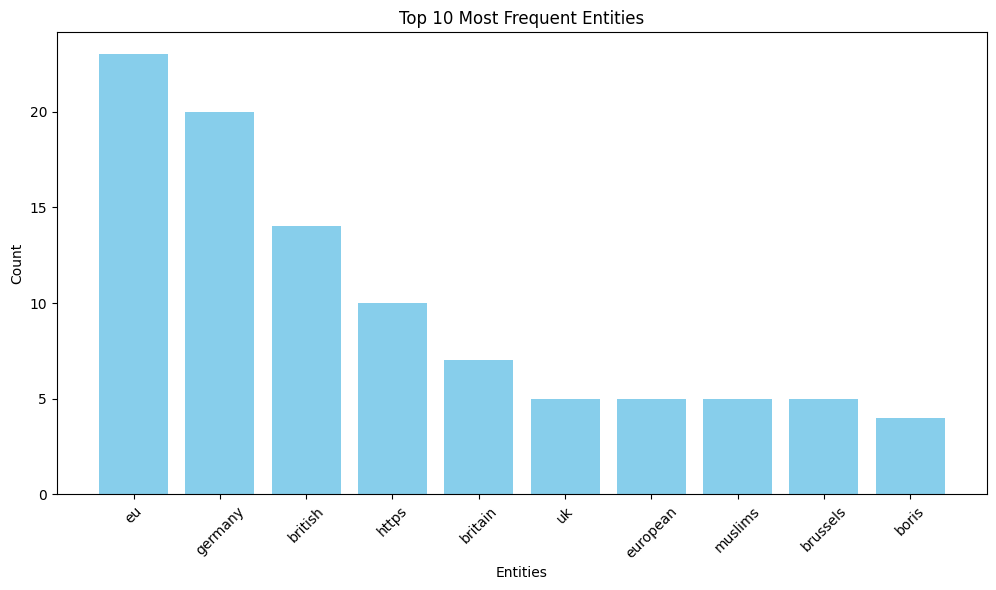

In [5]:
import spacy
from collections import defaultdict, Counter
import pandas as pd
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')

all_text = ' '.join(df['Post Name']) + ' ' + all_comments_close_to_brexit

# Process the combined text with spaCy
doc = nlp(all_text)

entities_to_redact = ['PERSON', 'ORG', 'GPE', 'NORP']

# Count the appearances of each relevant named entity
entity_counts = Counter(ent.text for ent in doc.ents if ent.label_ in entities_to_redact)

print("Entity Counts:")
for entity, count in entity_counts.most_common():
    print(f"{entity}: {count}")

# Function to replace entities with numbered versions in the text
entity_tracker = defaultdict(int)
def replace_entities_with_numbers(text):
    doc = nlp(text)
    new_text = text
    for ent in doc.ents:
        if ent.label_ in entities_to_redact:
            entity_tracker[ent.text] += 1
            new_text = new_text.replace(ent.text, f"{ent.text} [{entity_tracker[ent.text]}]")
    return new_text

replaced_text = replace_entities_with_numbers(all_text)

# Create a DataFrame from the entity counts
entity_counts_df = pd.DataFrame(entity_counts.items(), columns=['Entity', 'Count'])

top_10_entities_df = entity_counts_df.sort_values(by='Count', ascending=False).head(10)

# Plot the first 10 most frequent entities
plt.figure(figsize=(12, 6))
plt.bar(top_10_entities_df['Entity'], top_10_entities_df['Count'], color='skyblue')
plt.xlabel('Entities')
plt.ylabel('Count')
plt.title('Top 10 Most Frequent Entities')
plt.xticks(rotation=45)
plt.show()


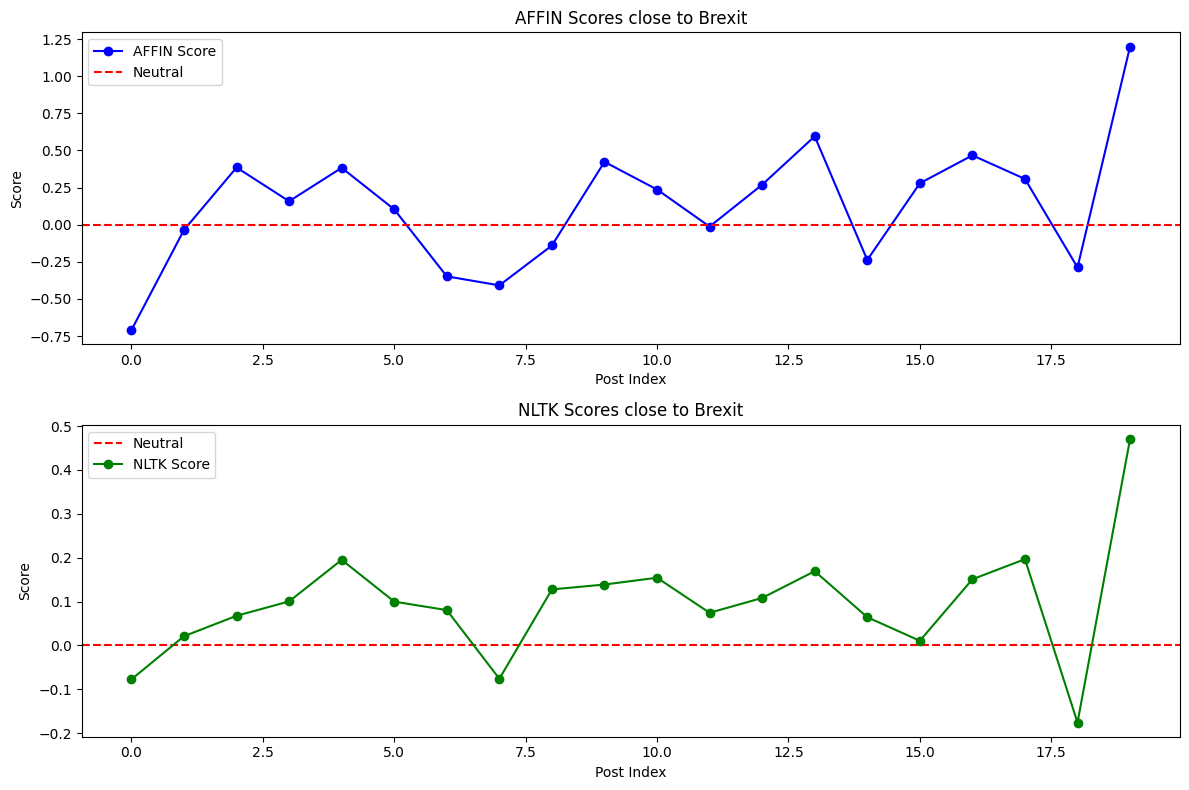

In [6]:
import matplotlib.pyplot as plt

affin_values = df['AFFIN Score']
nltk_values = df['NLTK Score']
x_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(x_labels, affin_values, marker='o', color='b', label='AFFIN Score')

ax1.axhline(y=0, color='r', linestyle='--', label='Neutral')

ax1.set_title('AFFIN Scores close to Brexit')
ax1.set_xlabel('Post Index')
ax1.set_ylabel('Score')
ax1.legend()

ax2.axhline(y=0, color='r', linestyle='--', label='Neutral')

ax2.plot(x_labels, nltk_values, marker='o', color='g', label='NLTK Score')
ax2.set_title('NLTK Scores close to Brexit')
ax2.set_xlabel('Post Index')
ax2.set_ylabel('Score')
ax2.legend()

plt.tight_layout()

plt.show()

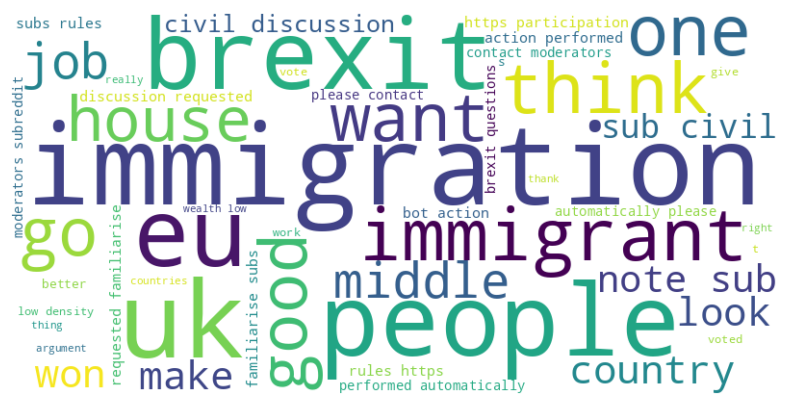

In [7]:
#Positive cloud
!pip install wordcloud --quiet
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

# Create a WordCloud object
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=50, width=800, height=400)
print(wordcloud)
# Generate the word cloud from the text
wordcloud.generate(all_positive_comments_close_to_brexit)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

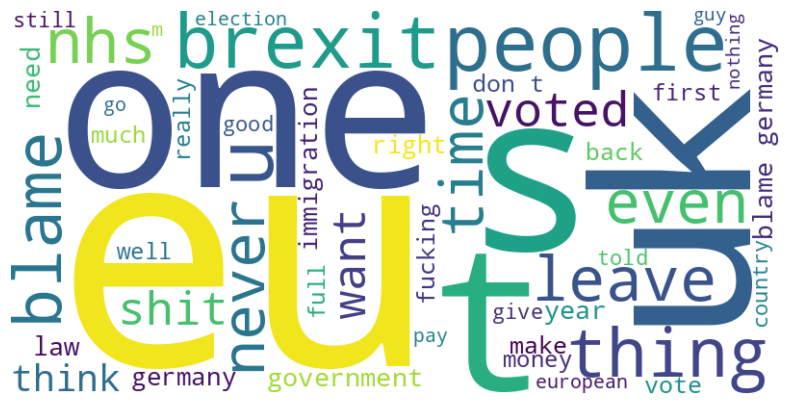

In [8]:
#Negative cloud
!pip install wordcloud --quiet
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

# Create a WordCloud object
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=50, width=800, height=400)

# Generate the word cloud from the text
wordcloud.generate(all_negative_comments_close_to_brexit)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [9]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

def clean_text(text):
    text = remove_stopwords(text)
    text = [word for word in word_tokenize(text)]
    text = [word for word in text if not re.match(r'[^\w\s]', word)]
    return ' '.join(text)

def get_sentiment_score(text):
    words = text.split()
    sentiment_score = 0
    count = 0
    for word in words:
        if word.lower() in word_scores:
            sentiment_score += word_scores[word.lower()]
            count += 1
    if count == 0:
        return 0
    average_score = sentiment_score / count
    return average_score

def analyze_sentiment_nltk_vader(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

with open("AFINN-en-165.txt", "r") as afinn_file:
    afinn_data = afinn_file.readlines()

word_scores = {}
for line in afinn_data:
    word, score = line.strip().split('\t')
    word_scores[word] = int(score)

hot_posts = reddit.subreddit('brexit').top(time_filter='year', limit=20)
all_comments_from_this_year = ""
all_positive_comments_from_this_year = ""
all_negative_comments_from_this_year = ""

data = []
for submission in hot_posts:
    print(f"Processing submission: {submission.title}")
    mean_AFFINN_SCORE = 0
    mean_NLTK_SCORE = 0
    count = 0

    submission.comments.replace_more(limit=0)
    comments_list = submission.comments.list()[:20]
    print(f"Number of comments: {len(comments_list)}")

    for top_level_comment in comments_list:
        try:
            text = top_level_comment.body
            if text.strip():
                print("BEFORE CLEANING: " + text)
                cleaned_text = clean_text(text)
                print("AFTER CLEANING: " + cleaned_text)

                affin_score = get_sentiment_score(cleaned_text)
                nltk_score = analyze_sentiment_nltk_vader(cleaned_text)

                mean_AFFINN_SCORE += affin_score
                mean_NLTK_SCORE += nltk_score
                count += 1

                all_comments_from_this_year += cleaned_text

                if affin_score > 0:
                    all_positive_comments_from_this_year += cleaned_text
                elif affin_score < 0:
                    all_negative_comments_from_this_year += cleaned_text

        except AttributeError:

            continue

    if count > 0:
        comment_AFFIN_MEAN = mean_AFFINN_SCORE / count
        comment_NLTK_MEAN = mean_NLTK_SCORE / count
        data.append({
            'Post Name': submission.title,
            'AFFIN Score': comment_AFFIN_MEAN,
            'NLTK Score': comment_NLTK_MEAN
        })

df = pd.DataFrame(data, columns=['Post Name', 'AFFIN Score', 'NLTK Score'])
print(df)

this_year_afin_score = df["AFFIN Score"].mean()
this_year_nltk_score = df["NLTK Score"].mean()
print(f"Mean AFFIN Score: {this_year_afin_score}")
print(f"Mean NLTK Score: {this_year_nltk_score}")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Processing submission: ‘I voted for Brexit and was told it wouldn’t affect expats – now I can’t live in my £13,000 Italian house’
Number of comments: 20
BEFORE CLEANING: Please note that this sub is for civil discussion. You are requested to familiarise yourself with the [subs rules](https://www.reddit.com/r/brexit/wiki/index) before participation.

*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/brexit) if you have any questions or concerns.*
AFTER CLEANING: please note sub civil discussion requested familiarise subs rules https participation i bot action performed automatically please contact moderators subreddit to=/r/brexit questions concerns
BEFORE CLEANING: Expat? Mate, you're an immigrant.
AFTER CLEANING: expat mate immigrant
BEFORE CLEANING: What is most surprising is how far he got in life (including buying a house abroad) by believing total bullshit sold by conmen. I suppose previous generatio

In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

all_text_data = all_comments_from_this_year

vectorizer = TfidfVectorizer(stop_words='english')

tfidf_matrix = vectorizer.fit_transform([all_text_data])

feature_names = vectorizer.get_feature_names_out()

tfidf_scores = tfidf_matrix.toarray()[0]

data_term_frequency = pd.DataFrame({
    'word': feature_names,
    'tf_idf': tfidf_scores
})

data_term_frequency_sorted = data_term_frequency.sort_values(by='tf_idf', ascending=False)

top_words = data_term_frequency_sorted.head(10)
print(top_words)


        word    tf_idf
336   brexit  0.524146
913       eu  0.354685
2690      uk  0.244339
1914  people  0.141874
1571    like  0.137933
2777    vote  0.122169
2778   voted  0.110347
1288   https  0.098524
2271   rules  0.086701
2624    time  0.086701


Entity Counts:
eu: 25
https: 20
british: 19
britain: 12
Brexit: 10
london: 9
italian: 8
brexit: 8
european: 7
france: 6
bbc: 6
italy: 5
germany: 5
spain: 5
UK: 4
new zealand: 4
russia: 4
american: 4
johnson: 4
rishi: 3
poland: 3
uk: 3
brussels: 3
boris johnson: 3
new york: 3
u.k.: 3
Italian: 2
British: 2
BBC: 2
EU: 2
putin: 2
customs: 2
french: 2
treasury: 2
german: 2
london stock exchange: 2
paris: 2
english: 2
hungary: 2
Britain: 1
n’t: 1
G7: 1
IMF: 1
London: 1
Vote Leave's: 1
Brexit ‘Brexit: 1
ARM: 1
New York: 1
London Brexit: 1
US: 1
Brexit Brexit: 1
Heseltine: 1
post-Brexit: 1
Spain: 1
Brits: 1
Briton: 1
Craft: 1
Beer: 1
eu free movement: 1
eurasian: 1
muslim: 1
fig: 1
eu hard brexit: 1
colin portsmouth: 1
business9: 1
sectioning9: 1
fault9: 1
connections eu: 1
empire9: 1
eu people benefitted leaving eu: 1
youtube https: 1
javid: 1
china india usa: 1
china: 1
lamb brazilian veal: 1
argentine: 1
httpsanswer justified: 1
eu trading bloc: 1
closer eu againi bet: 1
thomas: 1
x200b nic

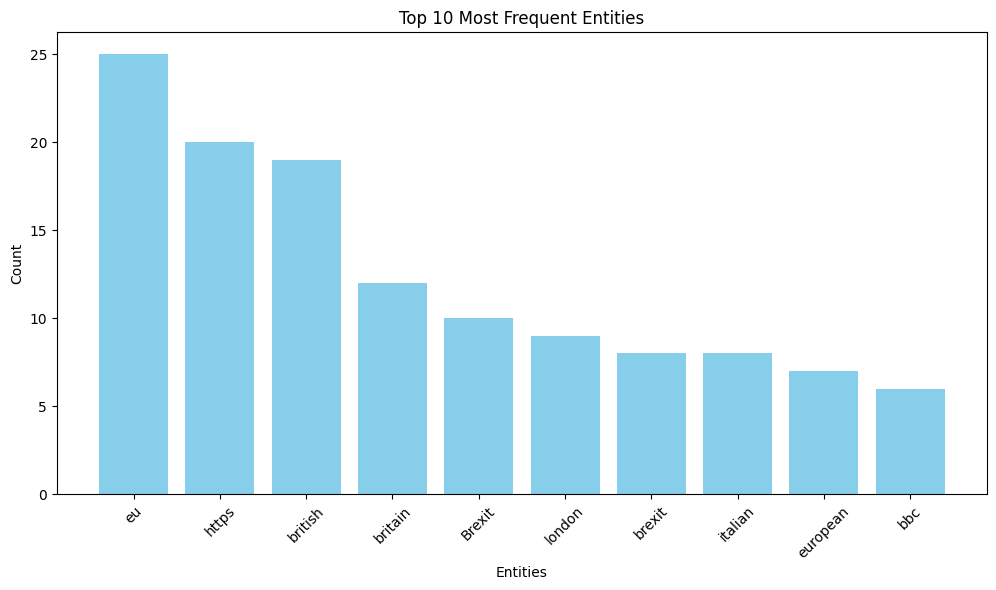

In [11]:
import spacy
from collections import defaultdict, Counter
import pandas as pd
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')

all_text = ' '.join(df['Post Name']) + ' ' + all_comments_from_this_year

doc = nlp(all_text)

entities_to_redact = ['PERSON', 'ORG', 'GPE', 'NORP']

entity_counts = Counter(ent.text for ent in doc.ents if ent.label_ in entities_to_redact)

print("Entity Counts:")
for entity, count in entity_counts.most_common():
    print(f"{entity}: {count}")

entity_tracker = defaultdict(int)
def replace_entities_with_numbers(text):
    doc = nlp(text)
    new_text = text
    for ent in doc.ents:
        if ent.label_ in entities_to_redact:
            entity_tracker[ent.text] += 1
            new_text = new_text.replace(ent.text, f"{ent.text} [{entity_tracker[ent.text]}]")
    return new_text

replaced_text = replace_entities_with_numbers(all_text)

entity_counts_df = pd.DataFrame(entity_counts.items(), columns=['Entity', 'Count'])

top_10_entities_df = entity_counts_df.sort_values(by='Count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_10_entities_df['Entity'], top_10_entities_df['Count'], color='skyblue')
plt.xlabel('Entities')
plt.ylabel('Count')
plt.title('Top 10 Most Frequent Entities')
plt.xticks(rotation=45)
plt.show()

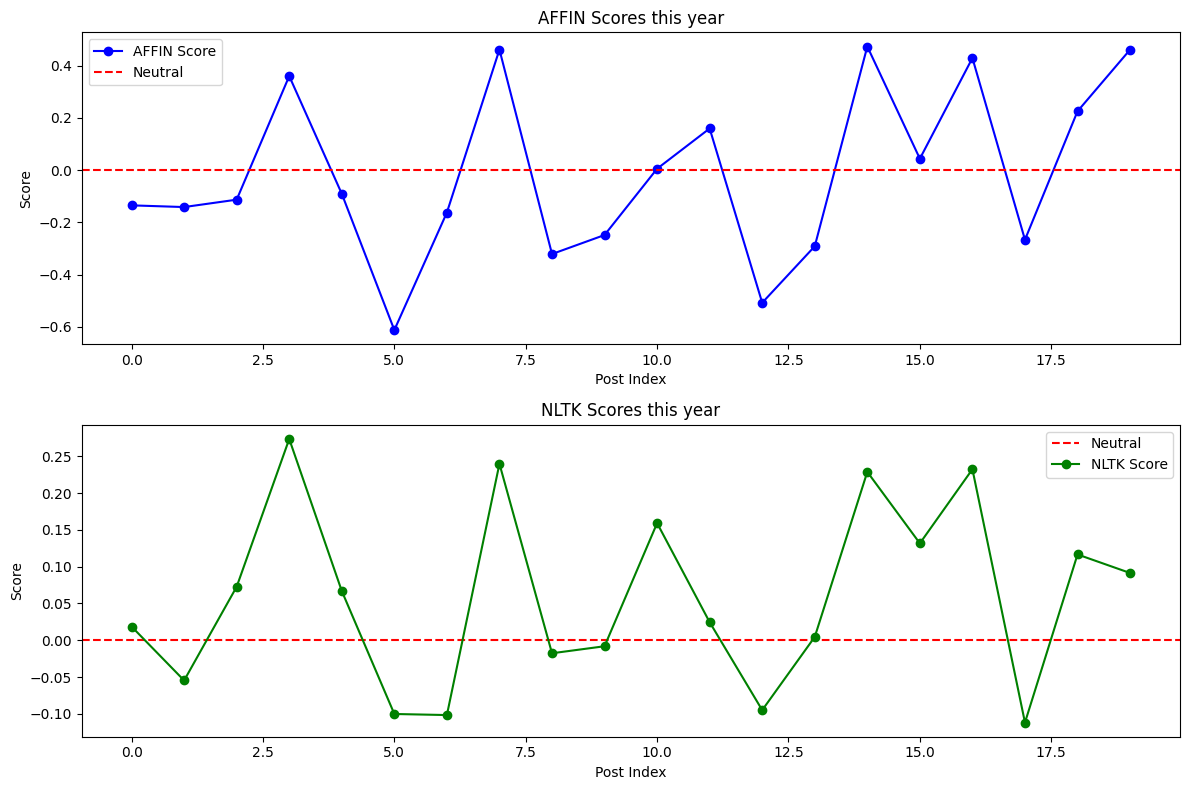

In [12]:
import matplotlib.pyplot as plt

affin_values = df['AFFIN Score']
nltk_values = df['NLTK Score']
x_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(x_labels, affin_values, marker='o', color='b', label='AFFIN Score')

ax1.axhline(y=0, color='r', linestyle='--', label='Neutral')

ax1.set_title('AFFIN Scores this year')
ax1.set_xlabel('Post Index')
ax1.set_ylabel('Score')
ax1.legend()

ax2.axhline(y=0, color='r', linestyle='--', label='Neutral')

ax2.plot(x_labels, nltk_values, marker='o', color='g', label='NLTK Score')
ax2.set_title('NLTK Scores this year')
ax2.set_xlabel('Post Index')
ax2.set_ylabel('Score')
ax2.legend()

plt.tight_layout()

plt.show()

In [13]:
import plotly.express as px

def bar(categories, x, y, color=["red", "blue", "red", "blue"], title="", xlab="", ylab=""):
  fig = px.bar(categories, x=x, y=y, color=color, height=400)
  fig.update_layout(
      title_text=title,
      xaxis_title_text=xlab,
      yaxis_title_text=ylab,
      bargap=0.2,
      bargroupgap=0.1
  )
  fig.show()

bar(categories=["Afine close to brexit", "NLTK close to brexit", "Afin this year", "NLTK this year"],
    x=["Afine close to brexit", "NLTK close to brexit", "Afin this year", "NLTK this year"],
    y=[close_to_brexit_afin_score, close_to_brexit_nltk_score, this_year_afin_score, this_year_nltk_score],
    title="Sentiment during Brexit and this year",
    xlab="Analysing tool",
    ylab="Sentiment score mean")


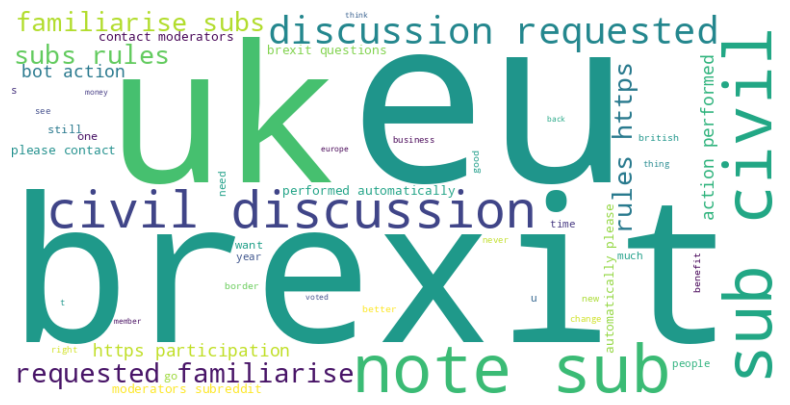

In [14]:
#Positive cloud
!pip install wordcloud --quiet
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

# Create a WordCloud object
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=50, width=800, height=400)
print(wordcloud)
# Generate the word cloud from the text
wordcloud.generate(all_positive_comments_from_this_year)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

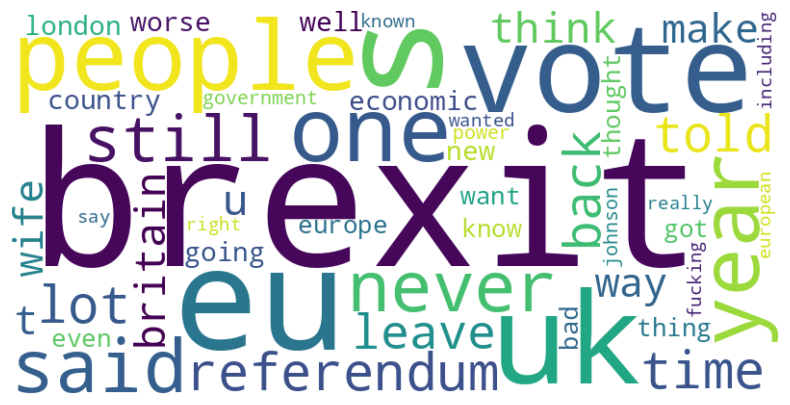

In [15]:
#Negative cloud
!pip install wordcloud --quiet
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

# Create a WordCloud object
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=50, width=800, height=400)

# Generate the word cloud from the text
wordcloud.generate(all_negative_comments_from_this_year)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()